# Test on sketches

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim import lr_scheduler
from tempfile import TemporaryDirectory

In [6]:
if torch.cuda.is_available():
    # Set the device to CUDA (GPU 0)
    device = torch.device("cuda:0")
else:
    # If no GPU is available, fall back to CPU
    device = torch.device("cpu")

In [7]:
base_path = "/home/intern/Documents/King_Hang/School/"
# os.chdir(BASE_PATH)

# path to animal classes
ANIMALS_PATH = './animals'

# Use only images in training folder
STYLE_ANIMALS_PATH = './style_animals/train/' 

# Sketch animals
SKETCH_PATH = './figures/'

In [8]:
from torchvision import transforms

data_dir = os.getcwd()
BATCH_SIZE = 4
IMAGE_SIZE = (224, 224)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a custom dataset
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 2])

        if self.transform:
            image = self.transform(image)

        return image, label

### Create dataloaders

1. Animals
2. Stylized Animals
3. Sketchfied animals

#### 1. Animals

##### Visualize

##### Data Augmentation, create datasets, create dataloaders

In [9]:
def create_dataloaders(path: str):
    data = {"imgpath": [] , "labels": [] }

    category = os.listdir(path)
    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)

    df = pd.DataFrame(data) 

    #Convert labels to numbers
    lb = LabelEncoder()
    df['encoded_labels'] = lb.fit_transform(df['labels'])

    # Split data into train-valid-test
    train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
    valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print("----------Train-------------")
    print(train_df[["imgpath", "labels"]].head(5))
    print(train_df.shape)
    print("--------Validation----------")
    print(valid_df[["imgpath", "labels"]].head(5))
    print(valid_df.shape)
    print("----------Test--------------")
    print(test_df[["imgpath", "labels"]].head(5))
    print(test_df.shape)

    plt.figure(figsize=(8,5))
    for i, row in test_df.sample(n=4).reset_index().iterrows():
        plt.subplot(2,2,i+1)
        image_path = row['imgpath']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(row["labels"])
        plt.axis('off')
    plt.show()

    data_dir = os.getcwd()
    BATCH_SIZE = 4
    IMAGE_SIZE = (224, 224)


    # create datasets
    trainset = ImageDataset(dataframe=train_df, root_dir=data_dir, transform=transform)
    validset = ImageDataset(dataframe=valid_df, root_dir=data_dir, transform=transform)
    testset = ImageDataset(dataframe=test_df, root_dir=data_dir, transform=transform)

    # create dataloaders
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)

    dataset_sizes = {'train': len(train_df), 'val': len(valid_df), 'test': len(test_df)}

    return trainloader, validloader, testloader, dataset_sizes

----------Train-------------
                                imgpath       labels
0         ./animals/goat/4f21ad4aa0.jpg         goat
1   ./animals/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./animals/moth/9e81bc5555.jpg         moth
3        ./animals/shark/40f50c6990.jpg        shark
4  ./animals/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                             imgpath    labels
0     ./animals/koala/9ca7babf11.jpg     koala
1      ./animals/goat/2e7b3347db.jpg      goat
2       ./animals/pig/1d8c1f3bbd.jpg       pig
3  ./animals/seahorse/37aaf8c8d7.jpg  seahorse
4  ./animals/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                             imgpath    labels
0     ./animals/otter/7c3868b76f.jpg     otter
1    ./animals/turtle/05e2720400.jpg    turtle
2     ./animals/whale/3b4307af02.jpg     whale
3      ./animals/lion/7d8f058238.jpg      lion
4  ./animals/seahorse/2cd0c57bad.jpg  seahorse
(487, 3)


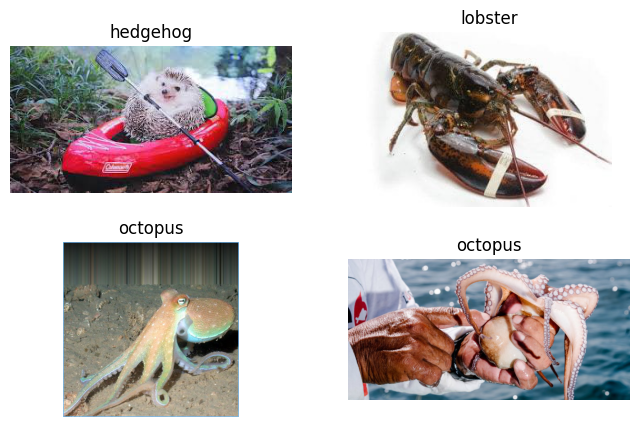

In [10]:
trainloader, validloader, testloader, dataset_sizes = create_dataloaders(ANIMALS_PATH)
dataloaders = {'train': trainloader, 'val': validloader, 'test': testloader}

##### Stylized Animals

----------Train-------------
                                            imgpath       labels
0         ./style_animals/train/goat/4f21ad4aa0.jpg         goat
1   ./style_animals/train/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./style_animals/train/moth/9e81bc5555.jpg         moth
3        ./style_animals/train/shark/40f50c6990.jpg        shark
4  ./style_animals/train/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                                         imgpath    labels
0     ./style_animals/train/koala/9ca7babf11.jpg     koala
1      ./style_animals/train/goat/2e7b3347db.jpg      goat
2       ./style_animals/train/pig/1d8c1f3bbd.jpg       pig
3  ./style_animals/train/seahorse/37aaf8c8d7.jpg  seahorse
4  ./style_animals/train/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                                         imgpath    labels
0     ./style_animals/train/otter/7c3868b76f.jpg     otter
1    ./style_animals/train/turt

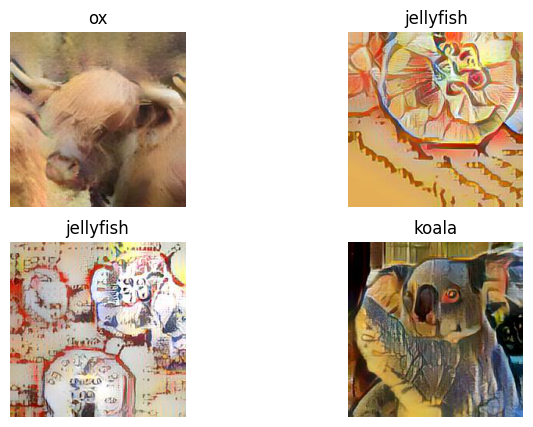

In [11]:
s_trainloader, s_validloader, s_testloader, s_dataset_sizes = create_dataloaders(STYLE_ANIMALS_PATH)
s_dataloaders = {'train': s_trainloader, 'val': s_validloader, 'test':s_testloader}

##### Sketch Animals

Note these are grayscale images

----------Train-------------
                                imgpath       labels
0         ./figures/goat/4f21ad4aa0.jpg         goat
1   ./figures/woodpecker/3a7fd9e840.jpg   woodpecker
2         ./figures/moth/9e81bc5555.jpg         moth
3        ./figures/shark/40f50c6990.jpg        shark
4  ./figures/hummingbird/8db010d774.jpg  hummingbird
(3779, 3)
--------Validation----------
                             imgpath    labels
0     ./figures/koala/9ca7babf11.jpg     koala
1      ./figures/goat/2e7b3347db.jpg      goat
2       ./figures/pig/1d8c1f3bbd.jpg       pig
3  ./figures/seahorse/37aaf8c8d7.jpg  seahorse
4  ./figures/mosquito/7cc15cecf2.jpg  mosquito
(1134, 3)
----------Test--------------
                             imgpath    labels
0     ./figures/otter/7c3868b76f.jpg     otter
1    ./figures/turtle/05e2720400.jpg    turtle
2     ./figures/whale/3b4307af02.jpg     whale
3      ./figures/lion/7d8f058238.jpg      lion
4  ./figures/seahorse/2cd0c57bad.jpg  seahorse
(487, 3)


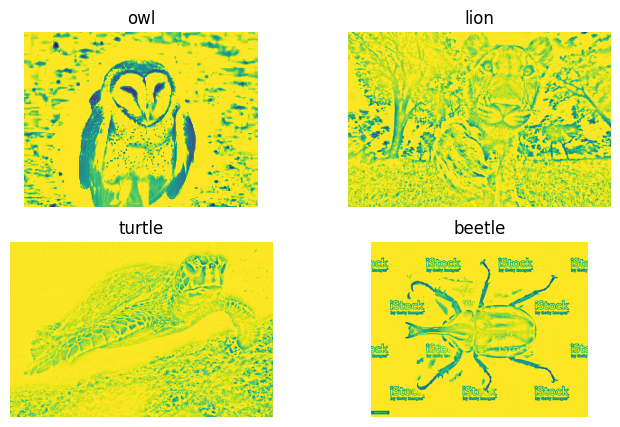

In [14]:
sh_trainloader, sh_validloader, sh_testloader, sh_dataset_sizes = create_dataloaders(SKETCH_PATH)
sh_dataloaders = {'train': sh_trainloader, 'val': sh_validloader, 'test': sh_testloader}

#### Top 5 Accuracy

Top-5 accuracy provides a more forgiving evaluation metric by considering whether the correct class is within the top 5 predicted classes. This is especially relevant in image recognition, where there can be a vast number of object categories. 

High top-5 accuracy indicates that the model is not only good at picking the most likely class but also capable of recognizing other plausible classes. 

It's especially useful when comparing models that have similar performance on the top-1 (single most likely class) accuracy but differ in their ability to provide a ranked list of possible classes.

In [12]:
def get_accuracy(model, testloader):

    model.eval()
    model = model.to(device)
    correct = 0
    total = 0
    predictions = list()

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Record predictions
            predictions.append(outputs)

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return predictions

def top_5_accuracy(predictions, labels):
    _, top5_predictions = torch.topk(predictions, 5, dim=1)
    correct = top5_predictions.eq(labels.view(-1, 1).expand_as(top5_predictions))
    top5_acc = correct.sum().item() / len(labels)
    return top5_acc

##### Training code

In [13]:
import time
# From Official Pytorch page: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
            
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Benchmarking Texture vs shape models

In [19]:
import sys

T_PATH = './texture-vs-shape/models/'

sys.path.append(T_PATH)

In [20]:
from load_pretrained_models import load_model

model_A = "resnet50_trained_on_SIN"
model_B = "resnet50_trained_on_SIN_and_IN"
model_C = "resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN"

### Model A finetuned on SKETCH

In [22]:
modelA_sketch = load_model(model_name=model_A)

modelA_sketch = modelA_sketch.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(modelA_sketch.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# animals dataset
modelA_sketch = train_model(modelA_sketch, criterion, optimizer_ft, exp_lr_scheduler, dataloaders=sh_dataloaders, num_epochs=25)

Using the ResNet50 architecture.
Epoch 0/24
----------
train Loss: 4.3361 Acc: 0.1252
val Loss: 2.9385 Acc: 0.3192

Epoch 1/24
----------
train Loss: 2.4712 Acc: 0.3800
val Loss: 2.3951 Acc: 0.4647

Epoch 2/24
----------
train Loss: 1.5049 Acc: 0.6002
val Loss: 2.0201 Acc: 0.5529

Epoch 3/24
----------
train Loss: 0.7912 Acc: 0.7960
val Loss: 2.0055 Acc: 0.5802

Epoch 4/24
----------
train Loss: 0.4272 Acc: 0.8960
val Loss: 1.7194 Acc: 0.6358

Epoch 5/24
----------
train Loss: 0.2132 Acc: 0.9574
val Loss: 1.6185 Acc: 0.6605

Epoch 6/24
----------
train Loss: 0.1367 Acc: 0.9730
val Loss: 1.5784 Acc: 0.6684

Epoch 7/24
----------
train Loss: 0.0879 Acc: 0.9862
val Loss: 1.3949 Acc: 0.7019

Epoch 8/24
----------
train Loss: 0.0695 Acc: 0.9897
val Loss: 1.4132 Acc: 0.7011

Epoch 9/24
----------
train Loss: 0.0522 Acc: 0.9942
val Loss: 1.3922 Acc: 0.7019

Epoch 10/24
----------
train Loss: 0.0522 Acc: 0.9929
val Loss: 1.4067 Acc: 0.6975

Epoch 11/24
----------
train Loss: 0.0496 Acc: 0.9923

In [23]:
predictions = get_accuracy(modelA_sketch, testloader)

Test Accuracy: 15.20%


In [24]:
modelA_sketch.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelA_sketch(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 32.31%


### Model B finetuned on SKETCH

In [40]:
modelB_sketch = load_model(model_name=model_B)

modelB_sketch = modelB_sketch.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(modelB_sketch.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# animals dataset
modelB_sketch = train_model(modelB_sketch, criterion, optimizer_ft, exp_lr_scheduler, dataloaders=sh_dataloaders, num_epochs=25)

Using the ResNet50 architecture.


/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 4.1998 Acc: 0.1352
val Loss: 2.8077 Acc: 0.3563

Epoch 1/24
----------
train Loss: 2.3888 Acc: 0.3911
val Loss: 2.4210 Acc: 0.4815

Epoch 2/24
----------
train Loss: 1.4491 Acc: 0.6203
val Loss: 2.0300 Acc: 0.5485

Epoch 3/24
----------
train Loss: 0.8148 Acc: 0.7928
val Loss: 1.8796 Acc: 0.5882

Epoch 4/24
----------
train Loss: 0.4053 Acc: 0.9100
val Loss: 1.3341 Acc: 0.6887

Epoch 5/24
----------
train Loss: 0.2392 Acc: 0.9471
val Loss: 1.4352 Acc: 0.6817

Epoch 6/24
----------
train Loss: 0.1589 Acc: 0.9688
val Loss: 1.3465 Acc: 0.7090

Epoch 7/24
----------
train Loss: 0.1039 Acc: 0.9820
val Loss: 1.2182 Acc: 0.7275

Epoch 8/24
----------
train Loss: 0.0803 Acc: 0.9865
val Loss: 1.1849 Acc: 0.7434

Epoch 9/24
----------
train Loss: 0.0705 Acc: 0.9892
val Loss: 1.2445 Acc: 0.7302

Epoch 10/24
----------
train Loss: 0.0597 Acc: 0.9921
val Loss: 1.2049 Acc: 0.7487

Epoch 11/24
----------
train Loss: 0.0556 Acc: 0.9910
val Loss: 1.1480 Acc: 0.7566

Ep

In [27]:
predictions = get_accuracy(modelB_sketch, testloader)

Test Accuracy: 42.71%


In [28]:
modelB_sketch.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelB_sketch(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 66.12%


##### Model C finetuned on Sketch

In [31]:
modelC_sketch = load_model(model_name=model_C)

modelC_sketch = modelC_sketch.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(modelC_sketch.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# animals dataset
modelC_sketch = train_model(modelC_sketch, criterion, optimizer_ft, exp_lr_scheduler, dataloaders=sh_dataloaders, num_epochs=25)


Using the ResNet50 architecture.


/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern/anaconda3/envs/kh_base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 4.2592 Acc: 0.1106
val Loss: 3.1933 Acc: 0.2954

Epoch 1/24
----------
train Loss: 2.6513 Acc: 0.3445
val Loss: 2.9947 Acc: 0.4277

Epoch 2/24
----------
train Loss: 1.7028 Acc: 0.5591
val Loss: 2.3379 Acc: 0.5106

Epoch 3/24
----------
train Loss: 1.1191 Acc: 0.7049
val Loss: 2.2913 Acc: 0.5212

Epoch 4/24
----------
train Loss: 0.5821 Acc: 0.8579
val Loss: 1.7969 Acc: 0.6129

Epoch 5/24
----------
train Loss: 0.3310 Acc: 0.9286
val Loss: 1.5523 Acc: 0.6825

Epoch 6/24
----------
train Loss: 0.2074 Acc: 0.9545
val Loss: 1.4307 Acc: 0.7028

Epoch 7/24
----------
train Loss: 0.1149 Acc: 0.9815
val Loss: 1.2802 Acc: 0.7354

Epoch 8/24
----------
train Loss: 0.0895 Acc: 0.9849
val Loss: 1.2607 Acc: 0.7372

Epoch 9/24
----------
train Loss: 0.0739 Acc: 0.9889
val Loss: 1.2407 Acc: 0.7381

Epoch 10/24
----------
train Loss: 0.0617 Acc: 0.9915
val Loss: 1.2679 Acc: 0.7399

Epoch 11/24
----------
train Loss: 0.0637 Acc: 0.9892
val Loss: 1.2062 Acc: 0.7496

Ep

In [32]:
predictions = get_accuracy(modelC_sketch, testloader)

Test Accuracy: 49.08%


In [33]:
modelC_sketch.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = modelC_sketch(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 73.91%


## Pretrain ImageNet + finetune on Sketch

In [35]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 90)

In [37]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# animals dataset
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders=sh_dataloaders, num_epochs=25)


Epoch 0/24
----------
train Loss: 1.9402 Acc: 0.4784
val Loss: 1.7825 Acc: 0.5282

Epoch 1/24
----------
train Loss: 1.2154 Acc: 0.6698
val Loss: 1.5968 Acc: 0.5855

Epoch 2/24
----------
train Loss: 0.7851 Acc: 0.7875
val Loss: 1.4286 Acc: 0.6393

Epoch 3/24
----------
train Loss: 0.5114 Acc: 0.8687
val Loss: 1.3081 Acc: 0.6905

Epoch 4/24
----------
train Loss: 0.3246 Acc: 0.9254
val Loss: 1.1758 Acc: 0.7178

Epoch 5/24
----------
train Loss: 0.2242 Acc: 0.9510
val Loss: 1.6657 Acc: 0.6614

Epoch 6/24
----------
train Loss: 0.1541 Acc: 0.9712
val Loss: 1.0939 Acc: 0.7566

Epoch 7/24
----------
train Loss: 0.0867 Acc: 0.9860
val Loss: 0.9394 Acc: 0.7848

Epoch 8/24
----------
train Loss: 0.0578 Acc: 0.9931
val Loss: 0.9137 Acc: 0.7901

Epoch 9/24
----------
train Loss: 0.0594 Acc: 0.9899
val Loss: 0.9523 Acc: 0.7892

Epoch 10/24
----------
train Loss: 0.0496 Acc: 0.9931
val Loss: 0.9331 Acc: 0.7937

Epoch 11/24
----------
train Loss: 0.0390 Acc: 0.9952
val Loss: 0.8814 Acc: 0.7998

Ep

In [38]:
predictions = get_accuracy(model_ft, testloader)

Test Accuracy: 52.77%


In [39]:
model_ft.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 77.19%
